In [1]:
# Adapted from
# https://github.com/salvadorgarciamunoz/kipet/blob/master/kipet/new_examples/Ex_12_multiple_experiments_concentration.py
#

In [37]:
from kipet import KipetModel
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
def build_model(kipet_model, datainit, rxnname):

    Tref = 298
    T = datainit['T']
    
    r1 = kipet_model.new_reaction(rxnname)

    r1.add_component('A', state = 'concentration', init = datainit['A'])
    r1.add_component('B', state = 'concentration', init = datainit['B'])
    r1.add_component('C', state = 'concentration', init = datainit['C'])
    r1.add_component('D', state = 'concentration', init = datainit['D'])

    r1.add_parameter('k1ref', init = 0.1, bounds = (0.0, 10.0))
    r1.add_parameter('k2ref', init = 0.1, bounds = (0.0, 10.0))
    r1.add_parameter('Ea1', init = 20, bounds = (0.0, 100.0))
    r1.add_parameter('Ea2', init = 20, bounds = (0.0, 100.0))


    def rule_odes(m, t):

        k1 = m.P['k1ref'] * pyo.exp(-m.P['Ea1']/8.314e-3 * (1/T - 1/Tref))
        k2 = m.P['k2ref'] * pyo.exp(-m.P['Ea2']/8.314e-3 * (1/T - 1/Tref))

        exprs = dict()
        exprs['A'] = -k1*m.Z[t,'A']*m.Z[t,'B']
        exprs['B'] = -k1*m.Z[t,'A']*m.Z[t,'B']-k2*m.Z[t,'B']*m.Z[t,'C']
        exprs['C'] = k1*m.Z[t,'A']*m.Z[t,'B']-k2*m.Z[t,'B']*m.Z[t,'C']
        exprs['D'] = k2*m.Z[t,'B']*m.Z[t,'C']
        return exprs

    
    r1.add_equations(rule_odes)
    
    return r1

In [57]:
datainit = {'Exp1': {'A': 1, 'B': 2, 'C': 0, 'D': 0, 'T': 298},
            'Exp2': {'A': 1, 'B': 1, 'C': 0, 'D': 0, 'T': 298},
            'Exp3': {'A': 1, 'B': 2, 'C': 0, 'D': 0, 'T': 273}}

In [58]:
kipet_model = KipetModel() 
r1 = build_model(kipet_model, datainit['Exp1'], 'Exp1')
r2 = build_model(kipet_model, datainit['Exp2'], 'Exp2')
r3 = build_model(kipet_model, datainit['Exp3'], 'Exp3')

In [59]:
dirname = '/home/paperspace/learn_kipet/my_data_sets/'
C_data_1 = pd.read_csv(dirname + 'ABCD_cb0_2_temp_298.csv', index_col = 0)
C_data_2 = pd.read_csv(dirname + 'ABCD_cb0_1_T_298.csv', index_col = 0)
C_data_3 = pd.read_csv(dirname + 'ABCD_cb0_1_T_273.csv', index_col = 0)

In [60]:
r1.add_dataset('C_data_1', category = 'concentration', data = C_data_1[['A', 'B', 'C', 'D']])
r2.add_dataset('C_data_2', category = 'concentration', data = C_data_2[['A', 'B', 'C', 'D']])
r3.add_dataset('C_data_3', category = 'concentration', data = C_data_3[['A', 'B', 'C', 'D']])

In [61]:
r1.set_times(0.0, 4.0)
r2.set_times(0.0, 7.0)
r3.set_times(0.0, 15.0)

In [62]:
r1.variances = {'A':1, 'B':1, 'C':1, 'D':1}
r2.variances = {'A':1, 'B':1, 'C':1, 'D':1}
r3.variances = {'A':1, 'B':1, 'C':1, 'D':1}

In [63]:
r1.settings.solver.linear_solver = 'ma27'
r2.settings.solver.linear_solver = 'ma27'
r3.settings.solver.linear_solver = 'ma27'
kipet_model.settings.solver.linear_solver = 'ma27'

In [64]:
kipet_model.run_opt()

Warning! Since Cm-matrix contains negative values Kipet is assuming a derivative of Cm has been inputted
times are: <class 'tuple'>
Warning! Since Cm-matrix contains negative values Kipet is assuming a derivative of Cm has been inputted
times are: <class 'tuple'>
times are: <class 'tuple'>
Warning! Since Cm-matrix contains negative values Kipet is assuming a derivative of Cm has been inputted
times are: <class 'tuple'>
0.0 4.0
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', 

Ipopt 3.12: nlp_scaling_method=gradient-based
linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     6004
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      952

Total number of variables............................:     1206
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraint

  27  1.0770009e-01 4.21e-10 5.85e-12  -8.6 6.34e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:   1.0770008726484344e-01    1.0770008726484344e-01
Dual infeasibility......:   5.8466009811297681e-12    5.8466009811297681e-12
Constraint violation....:   4.2124803645293696e-10    4.2124803645293696e-10
Complementarity.........:   2.5059035607926338e-09    2.5059035607926338e-09
Overall NLP error.......:   2.5059035607926338e-09    2.5059035607926338e-09


Number of objective function evaluations             = 149
Number of objective gradient evaluations             = 28
Number of equality constraint evaluations            = 149
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 28
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 27
Total CPU secs in IPOPT 

In [65]:
print("The estimated parameters are:")

for model, results in kipet_model.results.items():
     results.show_parameters

The estimated parameters are:

The estimated parameters are:
k1ref 0.9602581371111575
k2ref 2.043304292626539
Ea1 18.3478802225419
Ea2 37.154295477436555

The estimated parameters are:
k1ref 0.9602581371111575
k2ref 2.043304292626539
Ea1 18.3478802225419
Ea2 37.154295477436555

The estimated parameters are:
k1ref 0.9602581371111575
k2ref 2.043304292626539
Ea1 18.3478802225419
Ea2 37.154295477436555


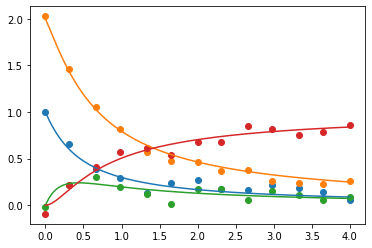

In [71]:
expt = 'Exp1'
fig, ax = plt.subplots()
for x in ['A', 'B', 'C', 'D']:
    results = kipet_model.results[expt]
    ax.scatter(results.Cm.index, results.Cm[x])
    ax.plot(results.Z.index, results.Z[x])

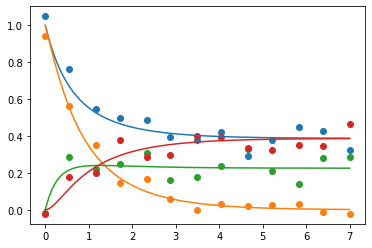

In [72]:
expt = 'Exp2'
fig, ax = plt.subplots()
for x in ['A', 'B', 'C', 'D']:
    results = kipet_model.results[expt]
    ax.scatter(results.Cm.index, results.Cm[x])
    ax.plot(results.Z.index, results.Z[x])

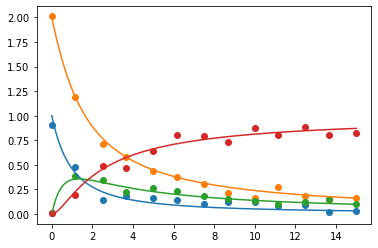

In [73]:
expt = 'Exp3'
fig, ax = plt.subplots()
for x in ['A', 'B', 'C', 'D']:
    results = kipet_model.results[expt]
    ax.scatter(results.Cm.index, results.Cm[x])
    ax.plot(results.Z.index, results.Z[x])